In [1]:
import torch
import DynamicalSystems.kernels as kernels
from DynamicalSystems.reduced_rank_regression import reduced_rank_regression
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse.linalg as lin
import tqdm
stride = 100
chignolin_path = f'../data/md_datasets/chignolin-unbiased/heavy_atoms_distances_stride_{stride}'
_data = torch.load(chignolin_path)

In [54]:
length_scale = 20
inputs = _data[:-1].cuda()
evolved_inputs = _data[1:].cuda()
kernel = kernels.Matern(length_scale=length_scale)
K = kernel(inputs).cpu().numpy()

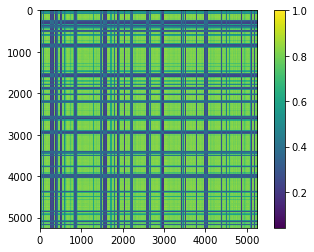

In [55]:
plt.imshow(K)
plt.colorbar()

In [44]:
evals, evecs = reduced_rank_regression(inputs, evolved_inputs, kernel, 10, regularizer=1e-1)

/home/novelli/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1257: UserWarning: M does not have the same type precision as A. This may adversely affect ARPACK convergence
  warnings.warn('M does not have the same type precision as A. '


(5247, 5247)


In [45]:
evals

array([ 5.9482962e-01+2.5067081e-08j,  1.5922487e-02+3.1789750e-07j,
        1.2371402e-02-8.4697685e-06j, -1.3615083e-03+8.6249365e-03j,
       -8.5181436e-03+5.2937094e-06j, -1.3825604e-03-8.6151250e-03j,
        7.5057731e-03+7.5175120e-07j,  2.7092150e-03+4.4976687e-03j,
        2.6447743e-03-4.5201271e-03j,  5.0813123e-04-1.0622345e-04j],
      dtype=complex64)

(-0.03868553168140352,
 0.6249970070552081,
 -0.009477128041908145,
 0.009486939525231719)

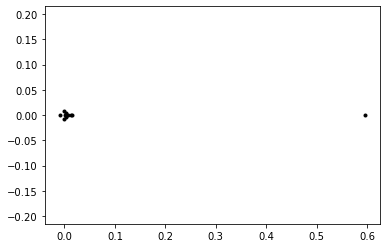

In [46]:
plt.plot(np.real(evals), np.imag(evals), 'k.')
plt.axis("equal")

In [47]:
K = kernel(inputs).cpu().numpy()
CVs = (K@evecs)/np.sqrt(K.shape[0])
scaled_CVs = np.real((CVs - np.mean(CVs, axis=0))/np.std(CVs, axis = 0))

In [48]:
CVs.shape

(5247, 10)

In [51]:
from stateinterpreter.utils.numerical_utils import gaussian_kde
def f(x):
    kde = gaussian_kde(scaled_CVs[:,x][:,np.newaxis], bandwidth=0.01)
    bounds = (scaled_CVs[:,x].min(),scaled_CVs[:,x].max())
    padding = 0
    cv_sample = np.linspace(bounds[0] - padding, bounds[1] + padding, 200)[:,np.newaxis]
    plt.plot(cv_sample, -kde.logpdf(cv_sample), 'k-')
    plt.margins(0)
    plt.xlabel(f"Kernel_DMD_{x}")
    plt.ylabel(r"Fes $[K_{\rm{B}}T]$")

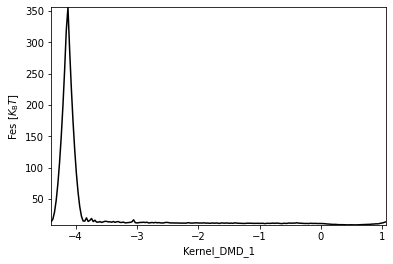

In [53]:
f(0)

In [151]:
K = kernel(inputs)
n = K.shape[0]
K/= n
evolved_K = kernel(evolved_inputs)/n
W = torch.rand_like(K, requires_grad=True)
J = torch.zeros_like(K)
Id = torch.eye(n).cuda()
model = -2*torch.trace(K@W@evolved_K) + torch.trace(torch.transpose(W, 0, 1)@K@K@W@evolved_K)

In [152]:
optimizer = torch.optim.NAdam([W])

100%|██████████| 1000000/1000000 [02:10<00:00, 7647.03it/s]


Text(0, 0.5, 'Residue')

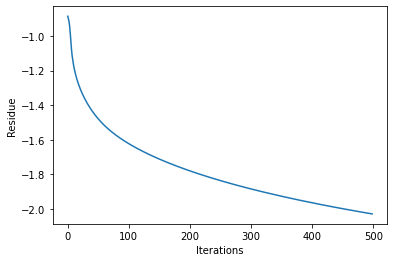

In [153]:
residues = []
for i in tqdm.tqdm(range(1000000)):
    W.grad = 2*K@(K@W - Id)@evolved_K
    if i > 1 and i%2000 == 0:
        model = -2*torch.trace(K@W@evolved_K) + torch.trace(torch.transpose(W, 0, 1)@K@K@W@evolved_K) + torch.trace(evolved_K)
        residues.append(model.item())
    optimizer.step()
residues = np.array(residues)
plt.plot(np.log(residues))
plt.xlabel('Iterations')
plt.ylabel('Residue')

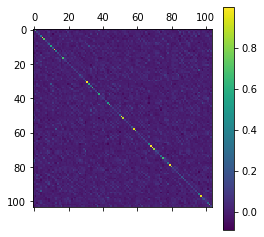

In [154]:
plt.matshow((K@W).cpu().detach().numpy())
plt.colorbar()

In [155]:
torch.linalg.cond(K)

tensor(5111.4688, device='cuda:0')